In [1]:
import requests
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

/Users/jalvarado91/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
gen1_dir = "./sprites/GenI"
gen2_dir = "./sprites/GenII"
gen3_dir = "./sprites/GenIII"
gen4_dir = "./sprites/GenIV"
gen5_dir = "./sprites/GenV"

In [3]:
def get_images_at(path):
    excluded = ['GenIA.png', 'GenIB.png', '.DS_Store', 'GenIIA.png', 'GenIIB.png',
               'CastformRain.png', 'CastformSnowy.png', 'CastformSunny.png', 'GenIIIA.png', 'GenIIIB.png',
               'GenIVA.png', 'GenIVB.png', 'GenVA.png', 'GenVB.png']
    images = os.listdir(path)
    return [os.path.join(path, u) for u in images if u not in excluded]

In [4]:
all_images = []
all_images += get_images_at(gen1_dir)
all_images += get_images_at(gen2_dir)
all_images += get_images_at(gen3_dir)
all_images += get_images_at(gen4_dir)
all_images += get_images_at(gen5_dir)

image_paths = np.array(all_images)

dataset = np.ndarray(shape=(len(image_paths), 64, 64, 3), dtype=np.uint8)

i = 0
for path in image_paths:
    pil_im = Image.open(path, 'r')
    img_arr = np.asarray(pil_im)
    trimmed = img_arr[0:64, 0:64, :3]
    dataset[i] = trimmed
    i += 1

print(dataset.shape)

(709, 64, 64, 3)


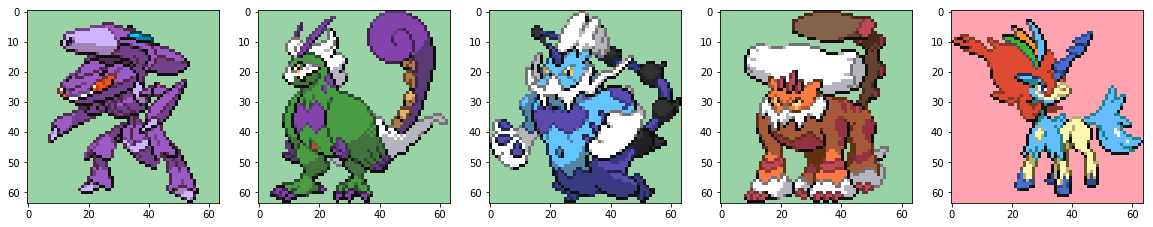

In [5]:
plt.figure(figsize=(20,10))
columns = 5
imgs = dataset[-5:]
for i, image in enumerate(imgs):
    plt.subplot(len(imgs) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [6]:
# print(dataset.shape)

size = len(dataset)
bottom = int(size * .8)

poke_train = dataset[:bottom]
poke_test = dataset[bottom:]

poke_train = poke_train.astype(np.float32) / 255.
poke_test = poke_test.astype(np.float32) / 255.
poke_train = poke_train.reshape((len(poke_train), np.prod(poke_train.shape[1:])))
poke_test = poke_test.reshape((len(poke_test), np.prod(poke_test.shape[1:])))

print(poke_train.shape)
# print(poke_train[:5])
print(poke_test.shape)
# print(poke_test[:5])




(567, 12288)
(142, 12288)


In [54]:
# print(dataset.shape)

size = len(dataset)
bottom = int(size * .8)

poke_train = dataset[:bottom]
poke_test = dataset[bottom:]

poke_train = poke_train.astype(np.float32) / 255.
poke_test = poke_test.astype(np.float32) / 255.
poke_train = np.reshape(poke_train, (len(poke_train), 64,64,3))
poke_test = np.reshape(poke_test, (len(poke_test),64,64,3 ))

print(poke_train.shape)
# print(poke_train[:5])
print(poke_test.shape)
# print(poke_test[:5])




(567, 64, 64, 3)
(142, 64, 64, 3)


### 1 Hidden Layer

#### Encoder

In [555]:
#target size of rep
encoding_dim = 32

#input
input_img = Input(shape=(12288,))

# encoded rep of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# reconstruction of the input
decoded = Dense(12288, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

#### Decoder

In [39]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

ValueError: Input 0 is incompatible with layer dense_14: expected axis -1 of input shape to have value 128 but got shape (None, 32)

In [38]:
encoder = Model(input_img, encoded)

### 3 layer deep network

#### Encoder

In [40]:
encoding_dim = 32
input_img = Input(shape=(12288,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(12288, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

In [41]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Convolutional Encoder

In [7]:
input_img = Input(shape=(64, 64, 3))

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

---

Configure the model

In [74]:
autoencoder.fit(poke_train, poke_train, \
                epochs=100, \
                batch_size=128, \
                shuffle=True, \
                validation_data=(poke_test, poke_test))

Train on 567 samples, validate on 142 samples
Epoch 1/100
567/567 [==============================] - 0s 715us/step - loss: 0.6057 - val_loss: 0.6105
Epoch 2/100
567/567 [==============================] - 0s 601us/step - loss: 0.6070 - val_loss: 0.6091
Epoch 3/100
567/567 [==============================] - 0s 563us/step - loss: 0.6049 - val_loss: 0.6090
Epoch 4/100
567/567 [==============================] - 0s 564us/step - loss: 0.6048 - val_loss: 0.6118
Epoch 5/100
567/567 [==============================] - 0s 560us/step - loss: 0.6081 - val_loss: 0.6100
Epoch 6/100
567/567 [==============================] - 0s 548us/step - loss: 0.6053 - val_loss: 0.6108
Epoch 7/100
567/567 [==============================] - 0s 548us/step - loss: 0.6060 - val_loss: 0.6097
Epoch 8/100
567/567 [==============================] - 0s 554us/step - loss: 0.6054 - val_loss: 0.6096
Epoch 9/100
567/567 [==============================] - 0s 561us/step - loss: 0.6051 - val_loss: 0.6092
Epoch 10/100
567/567 [=====

### Run Predictions

In [105]:
# encoded_imgs = encoder.predict(poke_test)
decoded_imgs = autoencoder.predict(poke_test)

In [106]:
print(decoded_imgs.shape)

(142, 64, 64, 3)


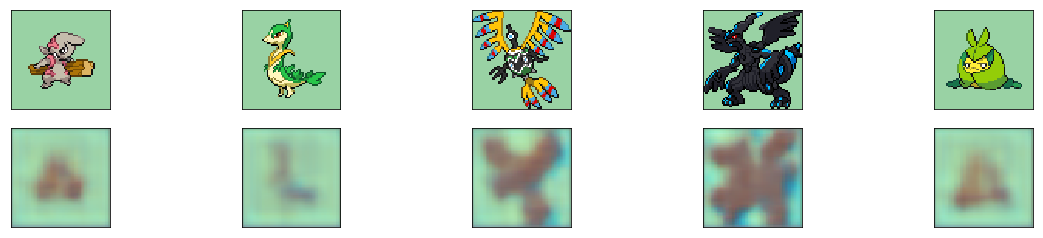

In [60]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(poke_test[i].reshape(64, 64, 3))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

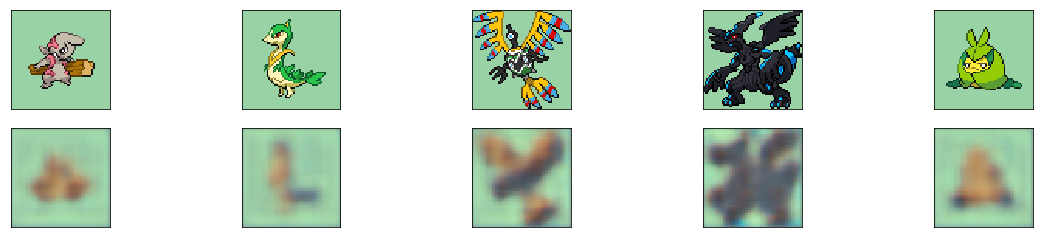

In [63]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(poke_test[i].reshape(64, 64, 3))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

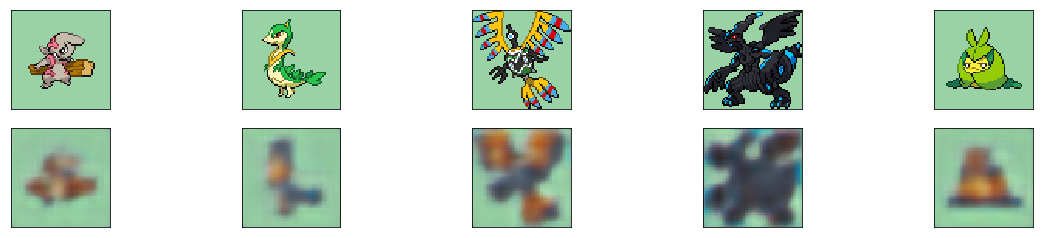

In [77]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(poke_test[i].reshape(64, 64, 3))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()